In [8]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

In [9]:
# Set parameters
drop_m6 = True # Optionally drop the outlier depressed mouse
C = 1e6 # Sets how much SVM will prioritize maximizing average distance from plane vs making sure ALL points are over the plane

In [10]:
# Load .mat file
data = sio.loadmat('artificial_processes.mat')
coordinates = data['artificial_coordinates3D_75']
# Label columns manually
column_names = ["Smallest Min", "Largest Max", "Largest Value Persistence", "Largest Clearance Value Persistence", "Largest Release Value Persistence", "Largest Time Persistence", "Largest Clearance Time Persistence", "Largest Release Time Persistence", "Average Value Persistence", "Average Clearance Value Persistence", "Average Release Value Persistence", "Average Time Persistence", "Average Clearance Time Persistence", "Average Release Time Persistence", "Difference Between Average CVP and Average RVP", "Difference Between Max CVP and Max RVP", "Difference Between Average CTP and Average RTP", "Difference Between Max CTP and Max RTP", "Largest Slope", "Largest Clearance Slope", "Largest Release Slope", "Average Slope", "Average Clearance Slope", "Average Release Slope", "Difference Between Average CS and Average RS", "Difference Between Max CS and Max RS", "Variance of Slopes", "Variance of Clearance Slopes", "Variance of Release Slopes", "Min Slope", "Min Clearance Slope", "Min Release Slope", "Average of x-to-60 Slopes (x = 1, 2, ..., 30)", "|Average of x-to-60 Slopes (x = 1, 2, ..., 30)|", "Signed Average Slope (Release is +, Clearance is -)"]
# Convert to df
coordinates_df = pd.DataFrame(coordinates, columns=column_names)
# One hot encode the cms / control mice
cms_labels = np.zeros(8, dtype=int)
control_labels = np.ones(10, dtype=int)
mouse_type = np.concatenate([cms_labels, control_labels])
# Make a df from that column
mouse_type_df = pd.DataFrame(mouse_type, columns=["Mouse Type"])
# Concatenate with og dataframe
df = pd.concat([mouse_type_df, coordinates_df], axis=1)
# Define columns that easily separate CMS from control and type labels
columns_to_drop = ["Mouse Type", "Smallest Min", "Largest Max", "Average of x-to-60 Slopes (x = 1, 2, ..., 30)", "|Average of x-to-60 Slopes (x = 1, 2, ..., 30)|"]

In [11]:
# Optionally drop the outlier depressed mouse
if drop_m6:
    df = df.drop(6+1)

# Get type labels
y = df['Mouse Type']
# Drop columns for final candidate coordinates
X = df.drop(columns_to_drop, axis=1)


In [12]:
# Do SVM

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train linear SVM
svm = SVC(kernel='linear', C=C)
svm.fit(X_scaled, y)

SVC(C=1000000.0, kernel='linear')

In [13]:
# Get feature importance (absolute value of coefficients)
feature_importance = abs(svm.coef_[0])

# Identify top 3 features
top_features_indices = feature_importance.argsort()[-3:][::-1]
print(top_features_indices)
top_features = X.columns[top_features_indices]

print("Top 3 features:", top_features.tolist())

[ 5 18 10]
Top 3 features: ['Largest Release Time Persistence', 'Largest Release Slope', 'Average Clearance Time Persistence']


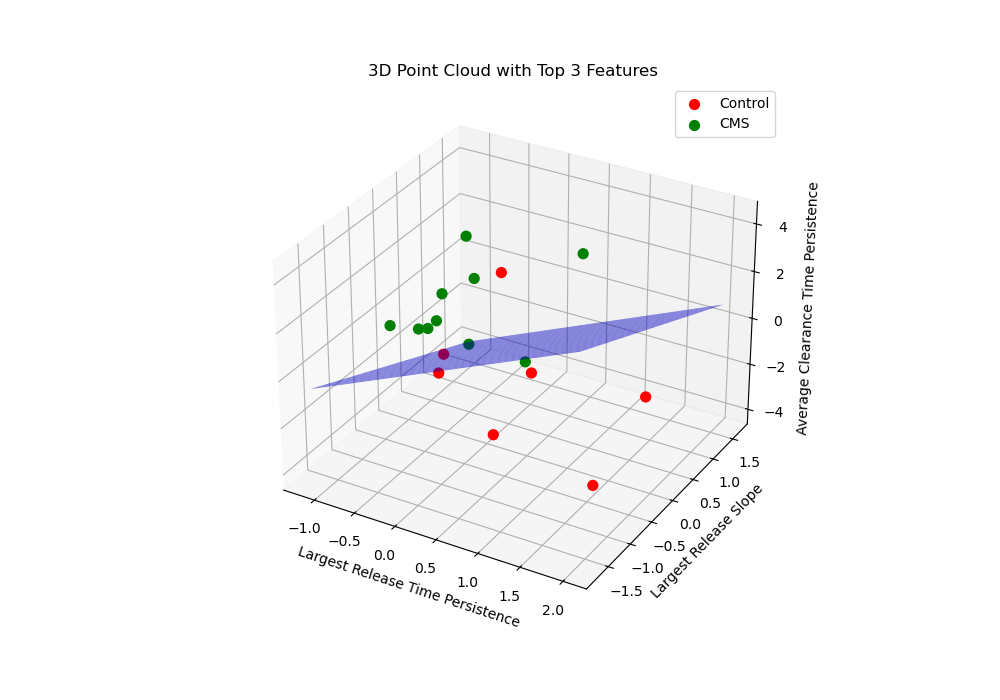

In [7]:
# Extract data for the top 3 features
X_top3 = X_scaled[:, top_features_indices]

# Plot 3D point cloud
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for label, color in zip([0, 1], ['red', 'green']):
    mask = y == label
    if label == 1:
        cat_label = "CMS"
    else:
        cat_label = "Control"
    
    ax.scatter(
        X_top3[mask, 0], X_top3[mask, 1], X_top3[mask, 2],
        label=cat_label, alpha=1, s=50, c=color
    )
    
# SVM Plane
# Get the coefficients and intercept for the top 3 features
w = svm.coef_[0][top_features_indices]  # Coefficients for the top 3 features
b = svm.intercept_[0]  # Intercept

# Create a meshgrid for the first two features (x, y)
x = np.linspace(X_top3[:, 0].min(), X_top3[:, 0].max(), 30)
y = np.linspace(X_top3[:, 1].min(), X_top3[:, 1].max(), 30)
x, y = np.meshgrid(x, y)

# Compute z values for the plane
z = (-w[0] * x - w[1] * y - b) / w[2]

# Plot the separation plane
ax.plot_surface(x, y, z, alpha=0.5, color='blue')

# Set axis labels
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
ax.set_title("3D Point Cloud with Top 3 Features")
ax.legend()

plt.show()